# VIDEOtag Dataset의 Annotation에서 Bbox 추가하는 과정

In [77]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
import utils
import model as modellib
from model import log
import coco
import visualize
import json
from pycocotools import mask as maskUtils
from skimage.measure import find_contours
from skimage.measure import approximate_polygon
from skimage.measure import moments

%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
IMAGE_DIR = "/Users/luke/Documents/ml_datasets/new/videotag/0101_0102/images"
JSON_ALL_DIR = "/Users/luke/Documents/ml_datasets/new/videotag/0101_0102/result_instances.json"
JSON_BBOX_DIR = "/Users/luke/Documents/ml_datasets/new/videotag/0101_0102/result_instances_with_bbox.json"

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)


# Create Model & Load Weight

In [3]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
# config.display()

# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", config=config, model_dir=MODEL_DIR)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

# Prepare COCO categories

In [4]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

# Prepare VIDEOtag, COCO category 맵핑 데이타

In [5]:
# Load VIDEOtag, COCO category 맵핑 데이타
map_data = open("assets/json/category.json").read()
tmp_videotag_coco_cate_map = json.loads(map_data)["categories"]

# dictionary로 생성
videotag_coco_cate_map = {}
for cate_data in tmp_videotag_coco_cate_map:
    videotag_coco_cate_map[cate_data['id']] = cate_data

# Prepare VIDEOtag Dataset

### 0101~0102 dataset
https://s3.ap-northeast-2.amazonaws.com/f-machine-learning-dataset/datasets/fingerplus/0101_0102.zip

In [6]:
json_data = open("/Users/luke/Documents/ml_datasets/new/videotag/0101_0102/instances.json").read()
data = json.loads(json_data)

videotag_anno = data['annotations']
videotag_imgs = data['images']
videotag_cate = data['categories']


videotag_img_anno_ids = {}
videotag_anno_dic = {}
videotag_cate_dic = {}

for anno in videotag_anno:
    videotag_anno_dic[anno['id']] = anno
    
for cate in videotag_cate:
    videotag_cate_dic[cate['id']] = cate
        
for image in videotag_imgs:
    anno_ids = []
    image_id = image['id']
    
    for anno in videotag_anno:
        anno_img_id = anno['image_id']
        anno_id = anno['id']
        if anno_img_id == image_id:
            anno_ids.append(anno_id)
    # if not len(annos) == 0:
    videotag_img_anno_ids[image_id] = anno_ids

In [7]:
print(videotag_imgs[1]['id'])
print(videotag_img_anno_ids[videotag_imgs[1]['id']])

199606
['297282', '297283']


# Detect & Extract Region

annotations : [{
  area,         // Number - 영역 넓이(w*h)
  bbox,         // [x,y,width,height], (Array(4))
  category_id,  // int
  id,           // int
  image_id,     // int
  iscrowd,      // 0 or 1 (get anns for given crowd label (False or True))
  segmentation  // Array - mask 데이터 (RLE or [polygon])
}

In [90]:
import cv2

def getAnnosByIds(anno_ids):
    result = []
    for anno_id in anno_ids:  
        result.append(videotag_anno_dic[anno_id])
        
    return result

def upateAnnoWithBbox(anno_id, bbox, segmentation):
    for anno in videotag_anno:
        if anno['id'] == anno_id:
            anno['bbox'] = bbox
            anno['segmentation'] = segmentation.tolist()
            return anno
            break
            
def insertAnno(anno):
    videotag_anno.append(anno)

extracted_annotations = []
# test_mask = []
test_anno = {}


START_ANNO_ID = 0


###################################################################
# 모든 이미지에 대하여 predict를 실시한다.
###################################################################
vt_img_total = len(videotag_imgs)
for vt_img_current, vt_img in enumerate(videotag_imgs): 
    
#     if vt_img_current < 8:
#         continue
        
    if vt_img_current > 3:
        break;
    
    print(str(vt_img_current)+'/'+str(vt_img_total))
    img_id = vt_img['id']
    
    
    ###################################################################
    # videotag image에 등록되어 있느 annotation이 있는지 확인 후, 로드
    ###################################################################
    vt_annos = getAnnosByIds(videotag_img_anno_ids[img_id])
    
    if len(vt_annos) == 0:
        continue
    
    
    ###################################################################
    # videotag image이 로드
    ###################################################################
    img_path = os.path.join(IMAGE_DIR, vt_img['file_name']) 
    image = skimage.io.imread(img_path)
    # If grayscale. Convert to RGB for consistency.
    if image.ndim != 3:
        image = skimage.color.gray2rgb(image)
        
    height, width = image.shape[:2]    
        
    
    ###################################################################
    # Run detection
    ###################################################################
    results = model.detect([image], verbose=0)

    # Result
    r = results[0]
    
    rois = r['rois'] # y1, x1, y2, x2
    scores = r['scores']
    masks = r['masks'] # (height, width, 검출된 데이타 갯수)
    class_ids = r['class_ids']
    
    
    # 확인용
    confirm_matching_classes = []
    confirm_vt_anno_points = []
                
    is_found = 0
    
    ###################################################################
    # 추출된 Annotation을 VIDEOtag Annotation과 비교
    ###################################################################
    for index, score in enumerate(scores):
        
        image_id = image_id
        category_id = class_ids[index]
        category_name = class_names[category_id]
        roi = rois[index]
        bbox = [int(roi[1]), int(roi[0]), int(roi[3] - roi[1]), int(roi[2] - roi[0])]
        mask = masks[:, :, index]
        
        '''
        edge detection 로직 구현필요.
        (앞뒤 포인트를 직선으로 연결했을 때 기울기가 급감할 때를 edge로 지정할 수 있지 않을까)
        '''
        
        padded_mask = np.zeros((mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
#         contours = find_contours(padded_mask, 0.5)
        contours = find_contours(padded_mask, 0)
        np_contours = np.array(contours)
        np_contours = np_contours[0]
        segmentation = approximate_polygon(np_contours, tolerance=2.5)
        print('추출된 Anno', category_name, score)
        
        '''
        ## 이 부분에 edge detection 로직 필요
        --확인필요. segmentation이 여러개의 polygon을 추출되었을 때 하나의 큰 덩어리로 만드는 로직이 필요할 것 같음 (필요없을 수도 있음. 
        COCO 이미 설정되어 있는 데이타가 2중 Array로 되었있음)
        --구현필요. segmentation이 1픽셀 단위로 데이타가 잡혀있어 필요없는 데이타는 줄이는 로직이 필요(edge만 잡아서 포인트로 등록)
        '''
        
        seg = maskUtils.encode(np.asfortranarray(mask))
        area = maskUtils.area(seg)
        
        annotation = {}
        annotation['bbox'] = bbox
        annotation['category_id'] = category_id
        annotation['id'] = START_ANNO_ID
        annotation['image_id'] = image_id
        annotation['iscrowd'] = 0
        annotation['area'] = area
        annotation['segmentation'] = [segmentation.flatten()].tolist()
        print('annotation[segmentation]', annotation['segmentation'])
        # 물체의 중심점 추출
        mu = cv2.moments(mask)
        point_x = int(mu['m10']/mu['m00'])
        point_y = int(mu['m01']/mu['m00'])
        
        annotation['x_pos'] = point_x
        annotation['y_pos'] = point_y
        START_ANNO_ID += 1
        
        
        ###################################################################
        # coco model에서 검출된 annotation들이 videotag annotation(정답)들과 비교하여
        # 일치할 경우가 있을 때, 해당 videotag annotation에 bbox정보를 추가한다.
        ###################################################################
        for vt_anno in vt_annos:
            vt_anno_id = vt_anno['id']
            vt_cate_id = vt_anno['category_id']
            vt_cate_data = videotag_cate_dic[vt_cate_id]
            vt_cate_name = vt_cate_data['name']
            
            vt_point_x = int(width*vt_anno['x_pos'])
            vt_point_y = int(height*vt_anno['y_pos'])
            
            
            coco_cate_ids = videotag_coco_cate_map[vt_cate_id]['coco_ids']
            if len(coco_cate_ids) == 0:
                continue
                
            # NOTE: 포인트가 마스크 영역에 속하는 확인
            if mask[vt_point_y][vt_point_x] == 0:
                continue
            
            for coco_cate_id in coco_cate_ids:
                if coco_cate_id == category_id:
                    print('찾았다', 'videotag : '+vt_cate_name, 'coco : '+category_name)
                    saved_anno = upateAnnoWithBbox(vt_anno_id, bbox, segmentation)
                    test_anno = saved_anno
                    if saved_anno:
                        extracted_annotations.append(saved_anno)
                        
                    confirm_vt_anno_points.append([vt_point_y-5, vt_point_x-5, vt_point_y+5, vt_point_x+5])
                    confirm_matching_classes.append([category_name, vt_cate_name])
                    is_found = 1
                    break
                    
        ###################################################################
        # 높은 score로 검출되었으나, VIDEOtag Dataset에는 없는 데이타는 Annotations에 추가한다
        ###################################################################
        if is_found == 0 and score > 0.9:
            # 물체의 중심점 추출
#             mu = cv2.moments(mask)
#             point_x = int(mu['m10']/mu['m00'])
#             point_y = int(mu['m01']/mu['m00'])
            print('검출되지 않았으나 추가', category_name, bbox, point_x, point_y)
#             print(mu)
#             annotation['x_pos'] = point_x
#             annotation['y_pos'] = point_y
            # save new Annotation (검출된)
            insertAnno(annotation)
            extracted_annotations.append(annotation)
            is_found = 1
            
            confirm_vt_anno_points.append([point_y-5, point_x-5, point_y+5, point_x+5])
            confirm_matching_classes.append([category_name, category_name])
            
        is_found = 0
                    
    if not len(confirm_matching_classes):
        print('매칭된 카테고리 확인 - ', confirm_matching_classes, confirm_vt_anno_points)
    print('----------------------------------------------------------------------')
    
    # if is_found:
    if not len(confirm_matching_classes):
        visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'], confirm_vt_anno_points)

# result_all = {}
# result_all['annotations'] = videotag_anno
# # result_all['images'] = videotag_imgs

# print(result_all)

# # print(result_all)
# with open(JSON_ALL_DIR, 'w') as outfile:
#     json.dump(result_all, outfile)

result_anno = {}
result_anno['annotations'] = extracted_annotations
# result_anno['images'] = videotag_imgs

print(result_anno)

with open(JSON_BBOX_DIR, 'w') as outfile:
    json.dump(result_anno, outfile)

0/1081
1/1081
추출된 Anno person 0.9999666
annotation[segmentation] [354. 460. 354.  58. 348.  57. 346.  46. 314.  46. 309.  58. 280.  77.
 203.  93. 191. 100. 191. 117. 204. 134. 244. 147. 249. 158. 245. 179.
 224. 214. 205. 223. 158. 205. 142. 203. 108. 214.  88. 216.  71. 236.
  68. 272.  76. 299.  85. 308. 110. 321. 168. 324. 188. 317. 208. 324.
 222. 342. 237. 387. 269. 431. 285. 445. 303. 450. 316. 460. 337. 465.
 354. 460.]
검출되지 않았으나 추가 person [46, 50, 432, 303] 253 255
----------------------------------------------------------------------
2/1081
추출된 Anno person 0.9995808
annotation[segmentation] [356. 632. 356. 602. 352. 601. 352. 575. 356. 574. 356. 487. 346. 482.
 320. 482. 269. 494. 250. 504. 229. 534. 176. 539. 161. 549. 158. 561.
 161. 595. 180. 608. 190. 608. 212. 598. 230. 597. 239. 606. 248. 626.
 262. 639. 347. 639. 356. 632.]
검출되지 않았으나 추가 person [475, 153, 163, 202] 563 275
추출된 Anno person 0.999574
annotation[segmentation] [262.  62. 253.  46. 222.  37. 197.  38. 145.  5

TypeError: Object of type 'int32' is not JSON serializable

# 외곽 라인 검출 확인

{'id': '297325', 'x_pos': 0.695993031358885, 'y_pos': 0.739938080495356, 'image_id': '199612', 'category_id': 'B02', 'bbox': [430, 220, 61, 135], 'segmentation': array([[356., 483.],
       [356., 432.],
       [352., 430.],
       [252., 434.],
       [230., 449.],
       [233., 475.],
       [243., 484.],
       [264., 492.],
       [296., 492.],
       [356., 483.]])}


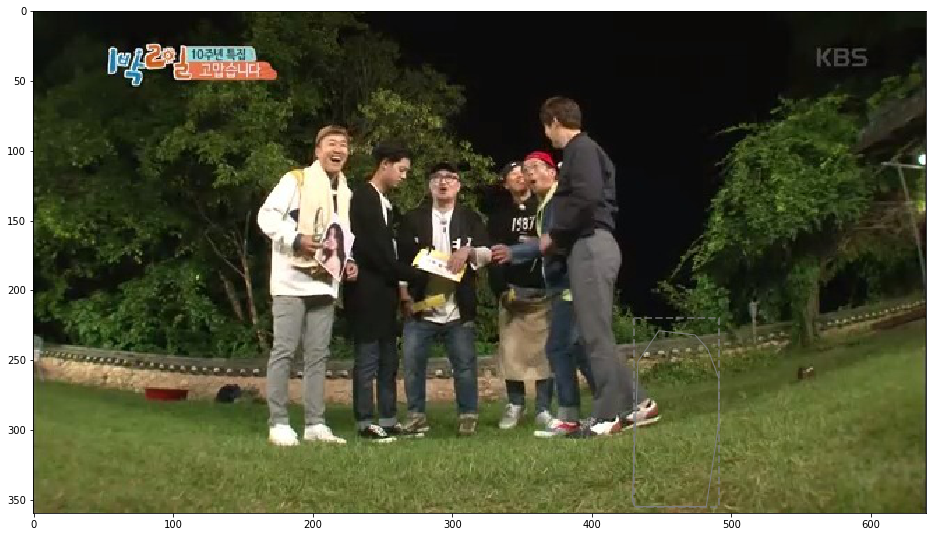

1 7 81
(1, 4) [[356. 483.]
 [356. 432.]
 [352. 430.]
 [252. 434.]
 [230. 449.]
 [233. 475.]
 [243. 484.]
 [264. 492.]
 [296. 492.]
 [356. 483.]] (1,)


AssertionError: 

In [43]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Polygon
from matplotlib.path import Path

# vt_img = videotag_imgs[]
# img_id = vt_img['id']
    
# vt_annos = getAnnosByIds(videotag_img_anno_ids[img_id])
# test_anno = vt_annos[0]
# img_path = os.path.join(IMAGE_DIR, vt_img['file_name']) 
    
print(test_anno)
    
    
# edgePixelCoordinates = np.array(test_mask.nonzero()).T
# padded_mask = np.zeros(
#     (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
# padded_mask[1:-1, 1:-1] = mask
# # contours = find_contours(padded_mask, 0.5)

# contours = find_contours(padded_mask, 0.5)
# np_contours = np.array(contours)
# np_contours = np_contours[0]
# segmentation = approximate_polygon(np_contours, tolerance=2.5)


    
img_path = os.path.join(IMAGE_DIR, vt_img['file_name']) 
image = skimage.io.imread(img_path)

height, width = image.shape[:2]    


color = (0.5, 0.5, 0.5, 1)


_, ax = plt.subplots(1, figsize=(16, 16))
masked_image = image.astype(np.uint32).copy()

x1, y1, w, h = test_anno['bbox']
p = patches.Rectangle((x1, y1), w, h, linewidth=2,
                      alpha=0.7, linestyle="dashed",
                      edgecolor=color, facecolor='none')
ax.add_patch(p)

# image = visualize.draw_box(image, [bbox_y1, bbox_x1, bbox_y2, bbox_x2], [255,0,0])
# image = visualize.draw_box(image, [point_y-5, point_x-5, point_y+5, point_x+5], [255,0,0])
# plt.figure(figsize=(14, 14 * height // width))
# plt.axis('off')

# for verts in test_anno["segmentation"]:
#     print('verts', verts)
#     verts = np.fliplr(verts) - 1
#     p = Polygon(verts, facecolor="none", edgecolor=color)
#     ax.add_patch(p)
    
verts = np.fliplr(test_anno["segmentation"]) - 1
p = Polygon(verts, facecolor="none", edgecolor=color)
ax.add_patch(p)
    
# for verts in segmentation:
#     verts = np.fliplr(verts) - 1
#     p = Polygon(verts, facecolor="none", edgecolor=color)
#     ax.add_patch(p)


ax.imshow(masked_image.astype(np.uint8))
plt.show()

print(np.array([test_anno['bbox']]).shape[0], masks.shape[-1], np.array(class_names).shape[0])

print(np.array([test_anno['bbox']]).shape, test_anno["segmentation"], np.array(['test']).shape)
visualize.display_instances(image, np.array([test_anno['bbox']]), np.array(test_anno["segmentation"]), np.array('test'), class_names, [0.9])



### 저장된 데이타를 확인합니다.

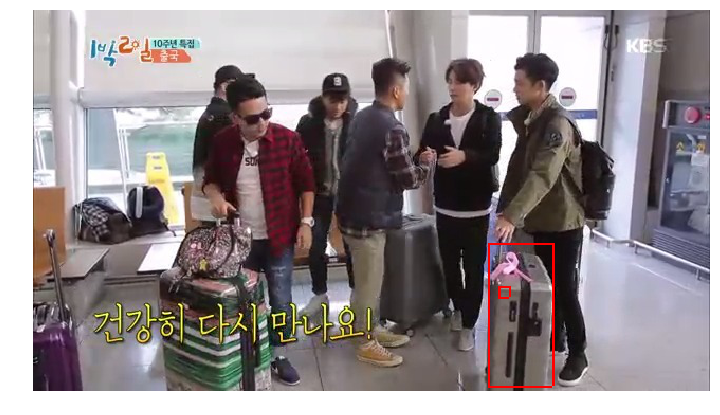

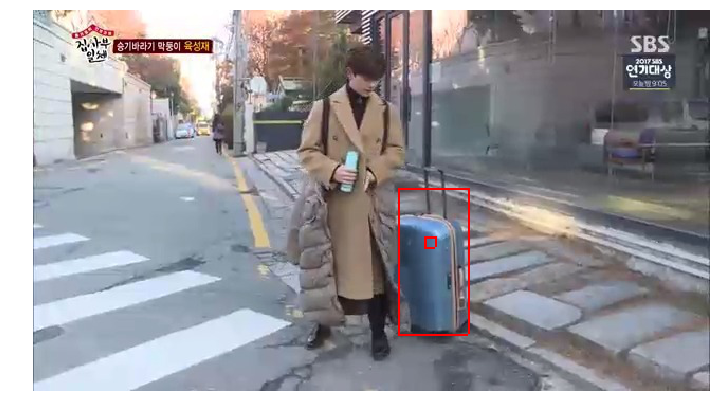

In [22]:
import json
import os
import skimage.io
import visualize
import matplotlib.pyplot as plt

ROOT_DIR = os.getcwd()

result_json_data = open("dataset/videotag/0101_0102/result/instances.json").read()
result_data = json.loads(result_json_data)

result_videotag_annos = result_data['annotations']
result_videotag_imgs = result_data['images']

result_videotag_imgs_dic = {}

for vt_img in result_videotag_imgs:
    img_id = vt_img['id']
    result_videotag_imgs_dic[img_id] = vt_img

for anno in result_videotag_annos:
    if 'bbox' in anno:
        vt_img = result_videotag_imgs_dic[anno['image_id']]
        
        img_path = os.path.join(ROOT_DIR, 'dataset/videotag/0101_0102/images', vt_img['file_name']) 
        image = skimage.io.imread(img_path)
        
        height, width = image.shape[:2]    
        
        point_x = int(width*anno['x_pos'])
        point_y = int(height*anno['y_pos'])
        
        bbox_x1 = anno['bbox'][0]
        bbox_y1 = anno['bbox'][1]
        bbox_x2 = bbox_x1+anno['bbox'][2]
        bbox_y2 = bbox_y1+anno['bbox'][3]
        image = visualize.draw_box(image, [bbox_y1, bbox_x1, bbox_y2, bbox_x2], [255,0,0])
        image = visualize.draw_box(image, [point_y-5, point_x-5, point_y+5, point_x+5], [255,0,0])
        plt.figure(figsize=(14, 14 * height // width))
        plt.axis('off')
        plt.imshow(image)
        plt.show()
        

In [34]:
import numpy
from PIL import Image, ImageDraw

# polygon = [(x1,y1),(x2,y2),...] or [x1,y1,x2,y2,...]
# width = ?
# height = ?

img = Image.new('L', (width, height), 0)
ImageDraw.Draw(img).polygon(polygon, outline=1, fill=1)
mask = numpy.array(img)

NameError: name 'polygon' is not defined